In [1]:
import os.path

from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci
import torchvision.models as models
dir(models)

C:\Program Files\Python39\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Program Files\Python39\lib\site-packages\torchaudio\backend\utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [1]:
cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg)

NameError: name 'AudioConfig' is not defined

In [3]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename"), 
                 splitter = RandomSplitter(seed = 42),
                 item_tfms = [ResizeSignal(3000), a2s, MaskFreq(), MaskTime(), SignalShifter(), SignalCutout(), ChangeVolume()],
                 batch_tfms = None,
                 get_y = ColReader("category"))

In [4]:
fnames = get_files("data/TIL_train_normalized/")
df = pd.DataFrame()
df['filename'] = [str(fn) for fn in fnames]
df['category'] = [str(fn).split(os.path.sep)[-2] for fn in fnames]

In [5]:
dbunch = auds.dataloaders(df, bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


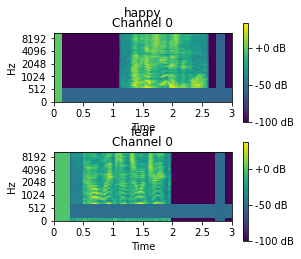

In [ ]:
dbunch.show_batch()

In [9]:
learn = cnn_learner(dbunch,
            resnet50,
            lr=1e-3, opt_func = ranger,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy, F1Score(average='weighted')])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\alien/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

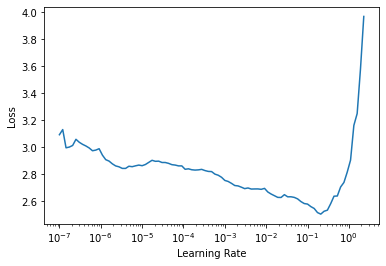

In [10]:
lr = learn.lr_find()

In [11]:
start_lr = lr[0]/10
print(start_lr)

0.002089296132326126


In [12]:
learn.fine_tune(30, base_lr = start_lr,
                cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3),
                SaveModelCallback(monitor='valid_loss', min_delta=0.002,fname='til_data_only_resnet50')])

Better model found at epoch 0 with valid_loss value: 1.4797940254211426.


Better model found at epoch 0 with valid_loss value: 1.3926727771759033.
Better model found at epoch 1 with valid_loss value: 1.2601107358932495.
Better model found at epoch 2 with valid_loss value: 1.1729108095169067.
Better model found at epoch 3 with valid_loss value: 1.0150080919265747.
Better model found at epoch 4 with valid_loss value: 0.9361319541931152.
Better model found at epoch 5 with valid_loss value: 0.812408983707428.
Better model found at epoch 6 with valid_loss value: 0.6994497776031494.
Better model found at epoch 8 with valid_loss value: 0.629059910774231.
Better model found at epoch 9 with valid_loss value: 0.548729658126831.
Better model found at epoch 11 with valid_loss value: 0.5126966834068298.
Better model found at epoch 12 with valid_loss value: 0.4663568437099457.
Better model found at epoch 14 with valid_loss value: 0.43377405405044556.
Better model found at epoch 15 with valid_loss value: 0.43048375844955444.
Better model found at epoch 16 with valid_loss v

In [13]:
learn.validate()

(#3) [0.4068877398967743,0.8585714101791382,0.8579945041671718]

In [14]:
preds, targs = learn.tta(n=5)
#accuracy(preds, targs).item()

In [15]:
from numpy import argmax
preds2 = [argmax(l) for l in preds]
import sklearn.metrics

In [16]:
sklearn.metrics.f1_score(preds2, targs, average='weighted')

0.9089767343976721

In [ ]:
sklearn.metrics.accuracy_score(preds2, targs)

0.9028571428571428

In [ ]:
preds, targs = learn.tta(n=1)
preds2 = [argmax(l) for l in preds]
print("f1",sklearn.metrics.f1_score(preds2, targs, average='macro'))
print("acc",sklearn.metrics.accuracy_score(preds2, targs))

f1 0.8582023872296469
acc 0.86


In [ ]:
preds, targs = learn.tta(n=10)
preds2 = [argmax(l) for l in preds]
print("f1",sklearn.metrics.f1_score(preds2, targs, average='macro'))
print("acc",sklearn.metrics.accuracy_score(preds2, targs))

f1 0.8866436868006454
acc 0.8871428571428571


In [ ]:
preds, targs = learn.tta(n=5)
preds2 = [argmax(l) for l in preds]
print("f1",sklearn.metrics.f1_score(preds2, targs, average='macro'))
print("acc",sklearn.metrics.accuracy_score(preds2, targs))

f1 0.8740262824645795
acc 0.8757142857142857


In [ ]:
preds, targs = learn.tta(n=5)
preds2 = [argmax(l) for l in preds]
print("f1",sklearn.metrics.f1_score(preds2, targs, average='macro'))
print("acc",sklearn.metrics.accuracy_score(preds2, targs))

f1 0.8895181414557587
acc 0.89


In [ ]:
(0.8895181414557587+0.8740262824645795+0.9030855450303473)/3

0.8888766563168952

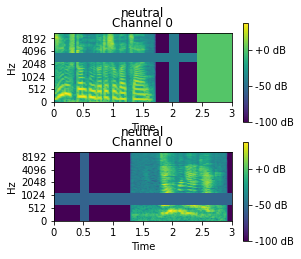

In [ ]:
dbunch.show_batch()

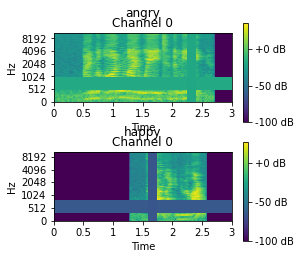

In [ ]:
dbunch[1].show_batch()

In [ ]:
avg = 0
for i in range(3):
  preds, targs = learn.tta(n=10)
  preds2 = [argmax(l) for l in preds]
  print("f1",sklearn.metrics.f1_score(preds2, targs, average='macro'))
  print("acc",sklearn.metrics.accuracy_score(preds2, targs))
  avg += sklearn.metrics.f1_score(preds2, targs, average='macro')
avg /= 3
print("avg fscore:",avg)

f1 0.8947376353344303
acc 0.8957142857142857


f1 0.8804525834886199
acc 0.8814285714285715


f1 0.8902216950661813
acc 0.8914285714285715
avg fscore: 0.8884706379630772


In [ ]:
avg = 0
for i in range(3):
  preds, targs = learn.tta(n=10)
  preds2 = [argmax(l) for l in preds]
  print("f1",sklearn.metrics.f1_score(preds2, targs, average='weighted'))
  print("acc",sklearn.metrics.accuracy_score(preds2, targs))
  avg += sklearn.metrics.f1_score(preds2, targs, average='weighted')
avg /= 3
print("avg fscore:",avg)

f1 0.896882707670209
acc 0.8957142857142857


f1 0.8869204798388182
acc 0.8857142857142857


f1 0.8924978961359921
acc 0.8914285714285715
avg fscore: 0.8921003612150065


In [ ]:
learn.save("til_data_only_resnet50_final")

Path('models/til_data_only_resnet50_final.pth')

In [ ]:
dicelearn = cnn_learner(dbunch, 
            resnet50,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=BaseLoss(),
            metrics=[accuracy,F1Score(average='macro')])

TypeError: ignored